In [1]:
GLOBAL_SEED = 1000

In [1]:
from az_common_funcs import *

2024-03-28 15:02:04,008 :: [INFO] :: Logger initialized WITHOUT file handler


In [2]:
from preprocessing_utils import preprocessing_utils

In [3]:
pu = preprocessing_utils()

In [4]:
df = pd.read_parquet(f"{data_dir}/S4_narrative_labelled_dataset.parquet")

In [5]:
df.head()

,review_id,sent_gte_3,cognitive_score,affective_score,spatial_embedding_score,temporal_embedding_score,narrativity_label,review_text
0,7778460,True,0.333333,0.333333,2,2,good,Yleen made our week long visit a very enjoyabl...
1,11649689,True,0.400000,0.600000,2,2,good,"They were super nice hosts, totally went out o..."
2,15108885,True,0.222222,0.333333,2,2,good,My 15-year-old daughter and I stayed at Farah...
3,26416346,True,0.333333,0.333333,2,2,good,Clean and convenient place to stay while we vi...
4,28564976,True,0.333333,0.333333,2,2,good,I had a wonderful time and was amazed at how m...


In [6]:
df.narrativity_label.value_counts()

narrativity_label
bad     997198
good     12913
Name: count, dtype: int64

In [8]:
cf = pu

In [9]:
df['review_length'] = df['review_text'].multicore_apply_by_chunks(cf.calculate_word_length, 16, 16)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63132/63132 [00:24<00:00, 2577.01it/s]


In [9]:
df.groupby('narrativity_label')['review_length'].describe()

,count,mean,std,min,25%,50%,75%,max
narrativity_label,,,,,,,,
bad,997198.0,28.784899,22.173939,3.0,16.0,23.0,33.0,885.0
good,12913.0,137.178657,102.420805,20.0,67.0,109.0,173.0,1217.0


In [11]:
df['review_num_sentences'] = df['review_text'].multicore_apply_by_chunks(cf.calculate_num_sentences, 16, 16)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63132/63132 [00:05<00:00, 10923.90it/s]


In [12]:
df.groupby('narrativity_label')['review_num_sentences'].describe().T

narrativity_label,bad,good
count,997198.000000,12913.000000
mean,3.674325,5.381476
std,1.291684,2.991247
min,3.000000,3.000000
25%,3.000000,3.000000
50%,3.000000,4.000000
75%,4.000000,7.000000
max,162.000000,31.000000


In [14]:
import seaborn as sns

<Axes: xlabel='review_num_sentences', ylabel='count'>

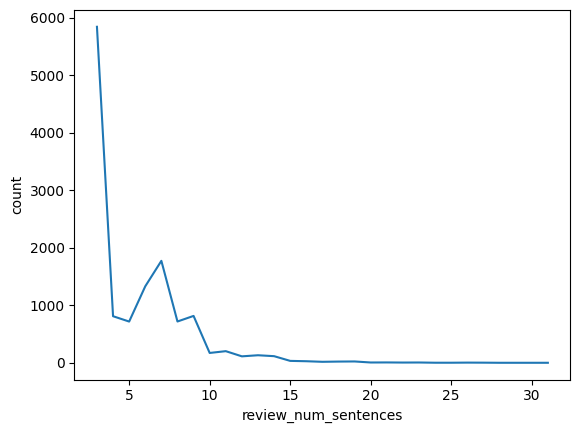

In [19]:
sns.lineplot(df.query('narrativity_label == "good"').review_num_sentences.value_counts().sort_index().iloc[:30])

<Axes: xlabel='review_num_sentences', ylabel='count'>

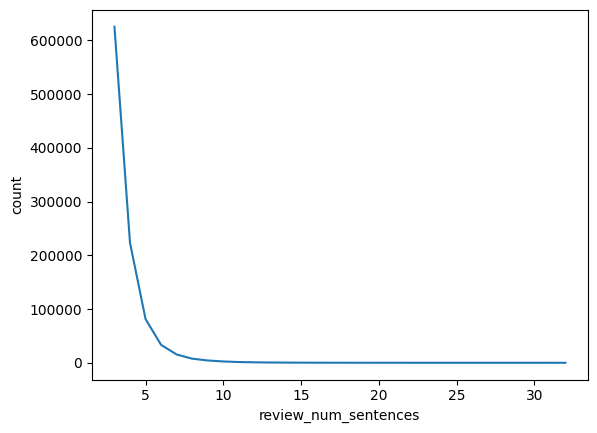

In [17]:
sns.lineplot(df.query('narrativity_label == "bad"').review_num_sentences.value_counts().sort_index().iloc[:30])

In [29]:
df.query('narrativity_label == "good"').review_num_sentences.value_counts().sort_index()

review_num_sentences
3     5845
4      811
5      718
6     1331
7     1774
8      719
9      816
10     172
11     203
12     113
13     132
14     116
15      34
16      28
17      18
18      22
19      24
20       6
21       7
22       5
23       6
24       2
25       2
26       4
27       3
28       1
31       1
Name: count, dtype: int64

In [31]:
df.query('narrativity_label == "bad"').review_num_sentences.value_counts().sort_index()

# 19 seems to be a good cutoff as the distribution is really sparse after that. 

review_num_sentences
3      625240
4      223332
5       81382
6       33325
7       15439
8        7639
9        4290
10       2460
11       1381
12        902
13        524
14        345
15        234
16        157
17        106
18         98
19         67
20         46
21         48
22         28
23         29
24         21
25         15
26         15
27         10
28          9
29          8
30          5
31          3
32          4
33          6
34          3
35          1
36          1
37          1
38          3
39          6
40          1
41          1
42          1
45          2
47          2
48          1
49          1
51          1
53          1
58          1
60          2
162         1
Name: count, dtype: int64

In [37]:
df_list = []
for i in range(3,20):
    df_temp_good = df.query(f'narrativity_label == "good" and review_num_sentences == {i!r}')
    goods_sampled = df_temp_good.shape[0]
    df_list.append(df_temp_good.copy())
    
    df_temp_bad = df.query(f'narrativity_label == "bad" and review_num_sentences == {i!r}')
    df_list.append(df_temp_bad.sample(goods_sampled, random_state = GLOBAL_SEED).copy())
    
df_final = pd.concat(df_list, ignore_index=True)

In [38]:
df_final.groupby('narrativity_label').review_num_sentences.describe().T

narrativity_label,bad,good
count,12876.000000,12876.000000
mean,5.330382,5.330382
std,2.835702,2.835702
min,3.000000,3.000000
25%,3.000000,3.000000
50%,4.000000,4.000000
75%,7.000000,7.000000
max,19.000000,19.000000


In [49]:
df_final.columns

Index(['review_id', 'sent_gte_3', 'cognitive_score', 'affective_score',
       'spatial_embedding_score', 'temporal_embedding_score',
       'narrativity_label', 'review_text', 'review_length',
       'review_num_sentences'],
      dtype='object')

In [50]:
df_final.rename(columns = {'review_text' : 'doc_a'}, inplace=True)

file_name = "S4_sentence_len_matched_labelled_pairs_F1.jsonl"

df_final.to_json(os.path.join(data_dir, file_name), orient='records', lines=True)

In [51]:
PROCESSED_DATASET_PATH = "/home/azikre/aadil/github/Transformer-Models-for-Text-Coherence-Assessment/processed_data/AIRBNB/"

cmd(f"cp {data_dir}/{file_name} {PROCESSED_DATASET_PATH}")

Running Command :: cp /home/azikre/aadil/data//S4_sentence_len_matched_labelled_pairs_F1.jsonl /home/azikre/aadil/github/Transformer-Models-for-Text-Coherence-Assessment/processed_data/AIRBNB/
output ::  
error ::  
return code ::  0
